In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import TimeSeriesSplit
import optuna
from joblib import dump, load
import xgboost as xgb
import xarray as xr
import zipfile
import plotly
import optuna.visualization as vis


import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
# # unzip file
# with zipfile.ZipFile('./data/RF_dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

### LightGBM:

In [6]:
check_this = pd.read_parquet("matched_lst_station_temp.parquet")

In [7]:
check_this.head()

elev     slope  aspect_cos  aspect_sin  \
time                y      x                                                    
2016-02-16 10:00:00 -33.15 18.02  19.705996  0.505718   -0.581291   -0.813696   
                           18.03  24.462826  0.318807    0.947378   -0.320116   
                           18.04  25.955309  0.748575    0.870594    0.492001   
                           18.10   6.762162  1.826431   -0.717692   -0.696360   
                           18.11   6.762162  1.826431   -0.717692   -0.696360   

                                   modis_LST  \
time                y      x                   
2016-02-16 10:00:00 -33.15 18.02  303.040009   
                           18.03  302.940002   
                           18.04  302.500000   
                           18.10  299.359985   
                           18.11  303.720001   

                                  station_ATLANTIS_INDUSTRIAL_CAPE_TOWN  \
time                y      x                                              
2016-02-16 10:00:00 -33.15 18.02                                    NaN   
                           18.03                                    NaN   
                           18.04                                    NaN   
                           18.10                                    NaN   
                           18.11                                    NaN   

                                  station_CAPE_TOWN_/_KIRSTENBOSCH  \
time                y      x                                         
2016-02-16 10:00:00 -33.15 18.02                               NaN   
                           18.03                               NaN   
                           18.04                               NaN   
                           18.10                               NaN   
                           18.11                               NaN   

                                  station_CT_AWS  station_GEELBEK  \
time                y      x                                        
2016-02-16 10:00:00 -33.15 18.02             NaN             26.6   
                           18.03             NaN             26.6   
                           18.04             NaN             26.6   
                           18.10             NaN             26.6   
                           18.11             NaN             26.6   

                                  station_JONKERSHOEK  station_LANGGEWENS  \
time                y      x                                                
2016-02-16 10:00:00 -33.15 18.02                  NaN                 NaN   
                           18.03                  NaN                 NaN   
                           18.04                  NaN                 NaN   
                           18.10                  NaN                 NaN   
                           18.11                  NaN                 NaN   

                                  station_MALMESBURY  \
time                y      x                           
2016-02-16 10:00:00 -33.15 18.02           28.200001   
                           18.03           28.200001   
                           18.04           28.200001   
                           18.10           28.200001   
                           18.11           28.200001   

                                  station_MOLTENO_RESERVIOR  station_PAARL  \
time                y      x                                                 
2016-02-16 10:00:00 -33.15 18.02                       21.0           27.5   
                           18.03                       21.0           27.5   
                           18.04                       21.0           27.5   
                           18.10                       21.0           27.5   
                           18.11                       21.0           27.5   

                                  station_ROBBEN_ISLAND  \
time                y      x                              
2016-02-16 10:00:00 -33.15 18.02   

In [8]:
dummy = check_this.reset_index()

In [10]:
dummy.time.max()

Timestamp('2024-03-10 09:00:00')

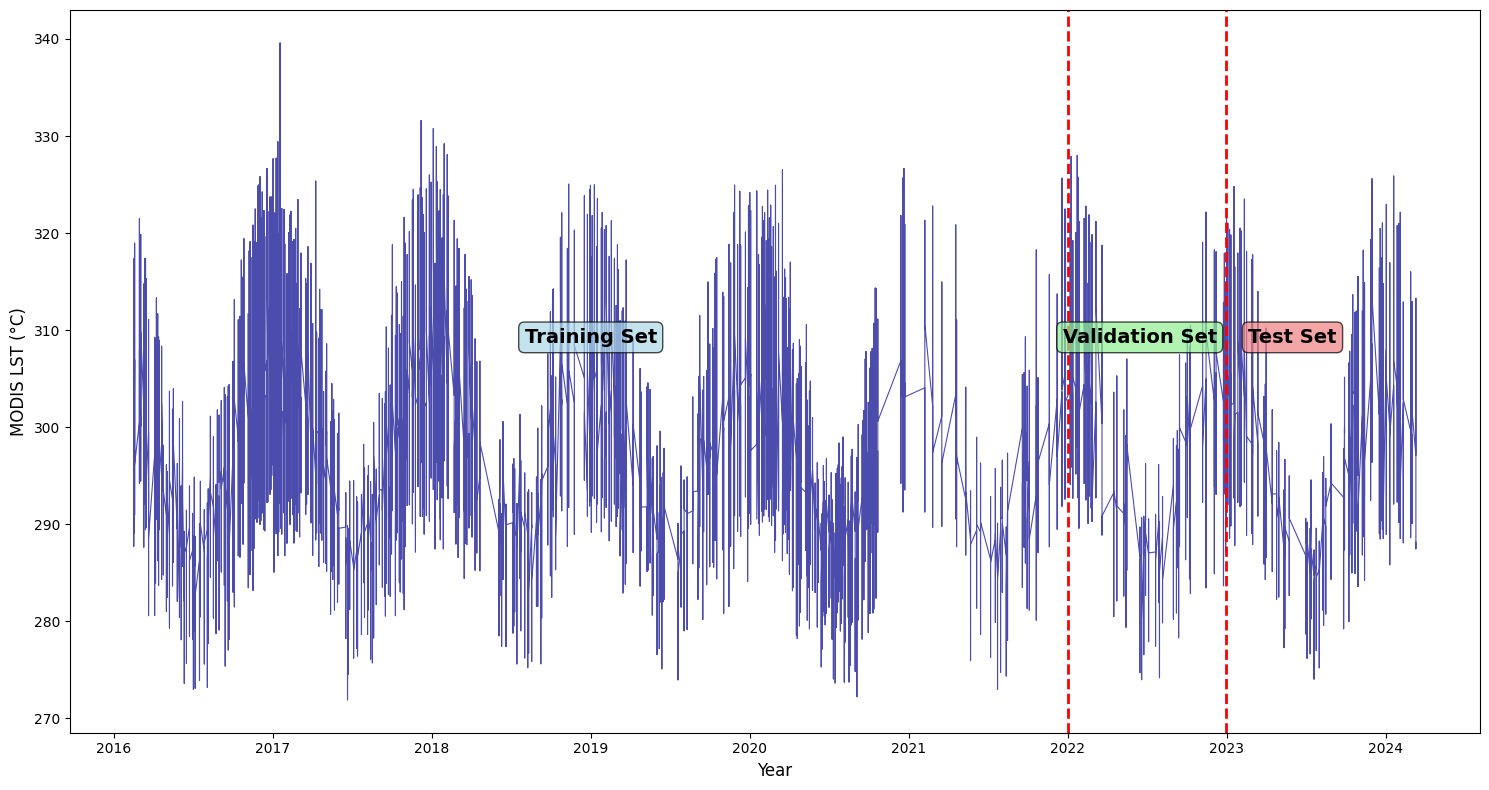

In [ ]:
time_dt = pd.to_datetime(dummy.time.values)

plt.figure(figsize=(15, 8))
plt.plot(time_dt, dummy.modis_LST.values, color='darkblue', alpha=0.7, linewidth=0.8)

# vertical lines for data splits
plt.axvline(x=pd.Timestamp('2022-01-01'), color='red', linestyle='--', linewidth=2)
plt.axvline(x=pd.Timestamp('2022-12-31'), color='red', linestyle='--', linewidth=2)

# text labels for each section
plt.text(pd.Timestamp('2019-01-01'), plt.ylim()[1] * 0.9, 'Training Set', 
        fontsize=14, fontweight='bold', ha='center', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.text(pd.Timestamp('2022-06-15'), plt.ylim()[1] * 0.9, 'Validation Set', 
        fontsize=14, fontweight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.text(pd.Timestamp('2023-06-01'), plt.ylim()[1] * 0.9, 'Test Set', 
        fontsize=14, fontweight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.xlabel('Year', fontsize=12)
plt.ylabel('MODIS LST (°C)', fontsize=12)
#plt.title('MODIS Land Surface Temperature Time Series with Data Splits', fontsize=14, fontweight='bold')
#plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
check_this.reset_index(inplace=True)

In [ ]:
check_this.set_index(['time','y','x'], inplace=True)

In [10]:
train = check_this[check_this.index.get_level_values('time')  < '2022-01-01']
val = check_this[(check_this.index.get_level_values('time')  >= '2022-01-01') & (check_this.index.get_level_values('time')  < '2023-01-01')]
test = check_this[check_this.index.get_level_values('time')  >= '2023-01-01']

In [11]:
X_train = train.drop(columns=['modis_LST'])
y_train = train['modis_LST']

X_val = val.drop(columns=['modis_LST'])
y_val = val['modis_LST']

X_test = test.drop(columns=['modis_LST'])
y_test = test['modis_LST']

In [12]:
y_test.to_xarray()

<xarray.DataArray 'modis_LST' (time: 62, y: 134, x: 158)> Size: 5MB
array([[[   nan,    nan,    nan, ..., 305.3 , 304.9 , 305.44],
        [   nan,    nan,    nan, ..., 307.92, 308.56, 309.  ],
        [   nan,    nan,    nan, ..., 307.98, 308.66, 308.8 ],
        ...,
        [   nan,    nan, 303.5 , ..., 314.34, 313.78, 313.26],
        [   nan, 303.84, 303.38, ..., 316.14, 315.82, 315.16],
        [   nan, 303.84, 303.42, ..., 316.32, 316.12, 315.54]],

       [[   nan,    nan,    nan, ..., 305.26, 305.32, 305.68],
        [   nan,    nan,    nan, ..., 303.6 , 305.22, 305.64],
        [   nan,    nan,    nan, ..., 302.54, 303.54, 304.98],
        ...,
        [   nan,    nan, 296.84, ..., 307.92, 307.48, 307.4 ],
        [   nan, 299.86, 300.6 , ..., 310.74, 310.74, 309.2 ],
        [303.06, 299.96, 299.6 , ..., 310.3 , 309.82, 309.26]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
...
        [   nan,    nan, 300.  , ..., 303.62, 302.8 , 302.5 ],
        [   nan, 298.3 , 299.7 , ..., 303.94, 303.2 , 302.56],
        [299.62, 298.2 , 297.7 , ..., 303.  , 303.5 , 303.32]],

       [[   nan,    nan,    nan, ..., 301.42, 301.64, 301.74],
        [   nan,    nan,    nan, ..., 301.34, 301.42, 302.5 ],
        [   nan,    nan,    nan, ..., 302.08, 302.  , 302.46],
        ...,
        [   nan,    nan, 296.84, ..., 310.2 , 310.24, 310.32],
        [   nan, 297.88, 298.24, ..., 310.3 , 310.4 , 310.2 ],
        [299.24, 299.2 , 299.12, ..., 310.36, 310.46, 310.2 ]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan, 297.28, ..., 310.2 , 310.24, 310.12],
        [   nan, 297.58, 297.54, ..., 310.66, 310.32, 309.48],
        [297.1 , 297.86, 297.52, ..., 309.56, 309.78, 309.64]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 496B 2023-01-03T10:00:00 ... 2024-03-10T09...
  * y        (y) float64 1kB -34.48 -34.47 -34.46 ... -33.17 -33.16 -33.15
  * x        (x) float64 1kB 18.02 18.03 18.04 18.05 ... 19.56 19.57 19.58 19.59

In [12]:
lgbm = LGBMRegressor(verbose=1)

In [13]:
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2729
[LightGBM] [Info] Number of data points in the train set: 5543083, number of used features: 19
[LightGBM] [Info] Start training from score 300.363878


LGBMRegressor(verbose=1)

In [14]:
lgbm.score(X_train, y_train)

0.9058565674767548

In [ ]:
# Make predictions
y_pred_train = lgbm.predict(X_train)
y_pred_val = lgbm.predict(X_val)
y_pred_test = lgbm.predict(X_test)

# Define a function to compute all metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    bias = np.mean(y_true - y_pred)  
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'Bias': bias, 'RMSE': rmse, 'R2': r2}

# Evaluate all sets
metrics_train = evaluate(y_train, y_pred_train)
metrics_val = evaluate(y_val, y_pred_val)
metrics_test = evaluate(y_test, y_pred_test)

# Display results
print("Train Metrics:", metrics_train)
print("Validation Metrics:", metrics_val)
print("Test Metrics:", metrics_test)


Train Metrics: {'MAE': 2.2381192104686294, 'Bias': 6.7157569735743255e-12, 'RMSE': 3.0060982133340066, 'R2': 0.9058565674767548}
Validation Metrics: {'MAE': 2.7576324563271872, 'Bias': 0.19915329372114296, 'RMSE': 3.5699692369340563, 'R2': 0.8754372538387732}
Test Metrics: {'MAE': 3.9456625573034048, 'Bias': -2.342153514432133, 'RMSE': 4.852842465188288, 'R2': 0.7420786368013043}


In [62]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': 1}

#### Performing Time Aware - Hyper Parameter optimization using Optuna:

In [9]:
lgb_reg = LGBMRegressor()

In [ ]:
# Implementing time aware cross validation splits during optimization:

def time_aware_cv_with_timeseriessplit(X_train, y_train, n_splits=5):
    """
    Use TimeSeriesSplit for time-aware cross-validation
    """
    # TimeSeriesSplit ensures temporal order is preserved
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    def objective(trial):
        params = {
            'max_bin': trial.suggest_int('max_bin', 30, 150),
            'max_depth': trial.suggest_int('max_depth', 4, 15),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'random_state': 42,
            'verbose': -1
        }
        
        scores = []
        
        for train_idx, val_idx in tscv.split(X_train):
            X_train_fold = X_train.iloc[train_idx] if hasattr(X_train, 'iloc') else X_train[train_idx]
            X_val_fold = X_train.iloc[val_idx] if hasattr(X_train, 'iloc') else X_train[val_idx]
            y_train_fold = y_train.iloc[train_idx] if hasattr(y_train, 'iloc') else y_train[train_idx]
            y_val_fold = y_train.iloc[val_idx] if hasattr(y_train, 'iloc') else y_train[val_idx]
            
            model = LGBMRegressor(**params)
            model.fit(X_train_fold, y_train_fold)
            
            y_pred = model.predict(X_val_fold)
            rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
            scores.append(rmse)
        
        # Return negative RMSE
        return -np.mean(scores)
    
    return objective

In [ ]:
objective_func = time_aware_cv_with_timeseriessplit(X_train, y_train, n_splits=5)

# Create study and optimize
study = optuna.create_study(
    direction='maximize',  # maximizing negative RMSE
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective_func, n_trials=15, show_progress_bar=True)

In [13]:
best_params = study.best_params
print("Best parameters:", best_params)
print("Best score:", study.best_value)

Best parameters: {'max_bin': 108, 'max_depth': 7, 'subsample': 0.6101204316740043, 'min_child_samples': 23, 'min_child_weight': 0.00154548031934508, 'num_leaves': 81, 'colsample_bytree': 0.6085490878980765, 'learning_rate': 0.29452088154832173, 'n_estimators': 297, 'reg_alpha': 3.410790269918185, 'reg_lambda': 0.6057041730828452}
Best score: -2.426341698301407


In [14]:
lgb_reg.set_params(**study.best_params)

LGBMRegressor(colsample_bytree=0.6085490878980765,
              learning_rate=0.29452088154832173, max_bin=108, max_depth=7,
              min_child_samples=23, min_child_weight=0.00154548031934508,
              n_estimators=297, num_leaves=81, reg_alpha=3.410790269918185,
              reg_lambda=0.6057041730828452, subsample=0.6101204316740043)

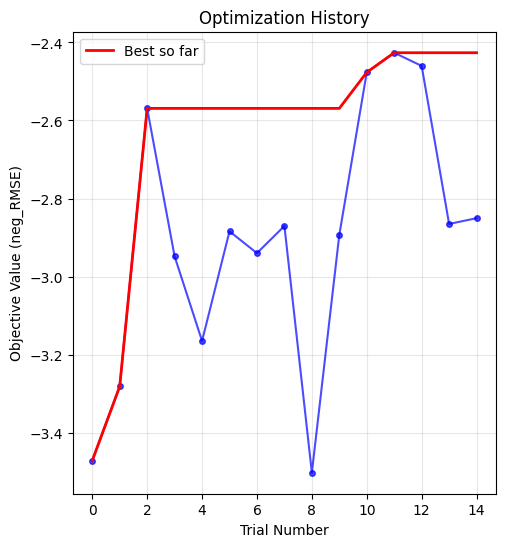

In [ ]:
trials_df = study.trials_dataframe()

# 1. Optimization History
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(trials_df['number'], trials_df['value'], 'b-o', alpha=0.7, markersize=4)
#plt.plot(trials_df['number'], trials_df['value'].cummax(), 'r-', linewidth=2, label='Best so far')
plt.xlabel('Trial Number')
plt.ylabel('Objective Value (neg_RMSE)')
plt.title('Optimization History')
plt.legend()
plt.grid(True, alpha=0.3)


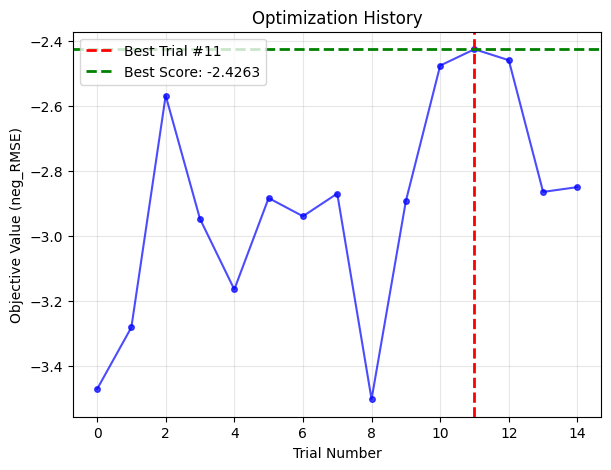

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get trial data from your study
trials_df = study.trials_dataframe()

# 1. Optimization History
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(trials_df['number'], trials_df['value'], 'b-o', alpha=0.7, markersize=4)

# Add lines showing the best trial
best_trial_number = trials_df.loc[trials_df['value'].idxmax(), 'number']
best_value = trials_df['value'].max()

plt.axvline(best_trial_number, color='red', linestyle='--', linewidth=2, 
           label=f'Best Trial #{int(best_trial_number)}')
plt.axhline(best_value, color='green', linestyle='--', linewidth=2, 
           label=f'Best Score: {best_value:.4f}')

plt.xlabel('Trial Number')
plt.ylabel('Objective Value (neg_RMSE)')
plt.title('Optimization History')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)


plt.show()
plt.savefig('./optuna_output.png')

In [24]:
lgb_reg.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.259308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 5543083, number of used features: 20
[LightGBM] [Info] Start training from score 300.363878


LGBMRegressor(colsample_bytree=0.8315969450087435,
              learning_rate=0.26178588399507413, max_bin=124, max_depth=15,
              min_child_samples=47, min_child_weight=0.02860925606456151,
              n_estimators=294, num_leaves=71, reg_alpha=9.818685091927954,
              reg_lambda=5.557273899358519, subsample=0.7328196902958738)

In [25]:
lgb_reg.score(X_train,y_train)

0.9436175893681622

### Testing Baseline Model's gap-filling performance:

In [26]:
elev_slope = xr.open_dataset("elev_slope.nc")

In [27]:
elev_slope = elev_slope.drop_vars('aspect')

In [28]:
df_elev_slope = elev_slope.to_dataframe().where(lambda x: x['slope'] > 0).dropna()

In [29]:
x_names = X_train.columns.tolist()

In [30]:
df_elev_slope

elev     slope  aspect_cos  aspect_sin
x     y                                                   
18.00 -33.15    0.000000  0.118283   -0.707107   -0.707107
18.01 -33.15    0.000000  0.574720   -0.599959   -0.800031
      -33.16    0.000000  0.199593   -0.707107   -0.707107
18.02 -33.15   19.705996  0.505718   -0.581291   -0.813696
      -33.16    0.000000  0.652060   -0.701546   -0.712625
...                  ...       ...         ...         ...
19.59 -34.39  417.107361  7.463654   -0.963706    0.266967
      -34.40  160.753769  6.373076   -0.997388    0.072235
      -34.41  115.577362  4.100270    0.973812   -0.227357
      -34.42  282.533417  3.758408    0.889138   -0.457639
      -34.43  310.249725  1.748742   -0.999885   -0.015190

[15283 rows x 4 columns]

In [31]:
X_train.count(axis=1).argmin()

np.int64(92)

In [33]:
X_train.iloc[92]

elev                                      79.187187
slope                                           NaN
aspect_cos                                      NaN
aspect_sin                                      NaN
station_ATLANTIS_INDUSTRIAL_CAPE_TOWN           NaN
station_CAPE_TOWN_/_KIRSTENBOSCH                NaN
station_CT_AWS                                  NaN
station_GEELBEK                           26.600000
station_JONKERSHOEK                             NaN
station_LANGGEWENS                              NaN
station_MALMESBURY                        28.200001
station_MOLTENO_RESERVIOR                 21.000000
station_PAARL                             27.500000
station_ROBBEN_ISLAND                     23.000000
station_SOUTH_AFRICAN_ASTRONOMICAL_OBS          NaN
station_WELLINGTON                              NaN
station_WORCESTER                               NaN
station_YSTERPLAAT                              NaN
station_YSTERPLANT(SAAFB)                 24.200001
doy         

In [35]:
stns_t = X_train.iloc[92].drop(df_elev_slope.columns)

In [36]:
X_t = df_elev_slope.assign(**{k: v for k, v in stns_t.items()})

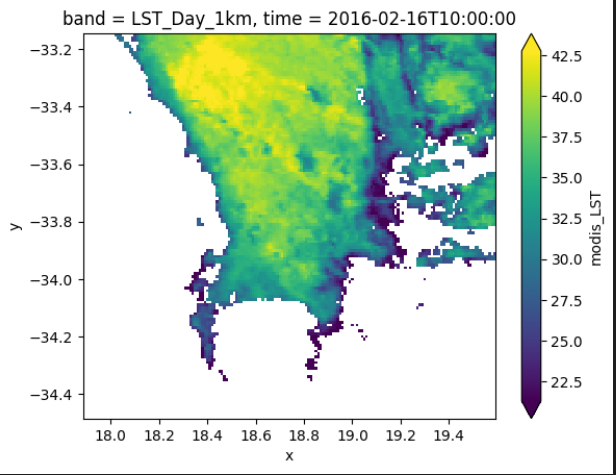

In [37]:
y_hat_t = pd.Series(lgb_reg.predict(X_t), index=X_t.index)

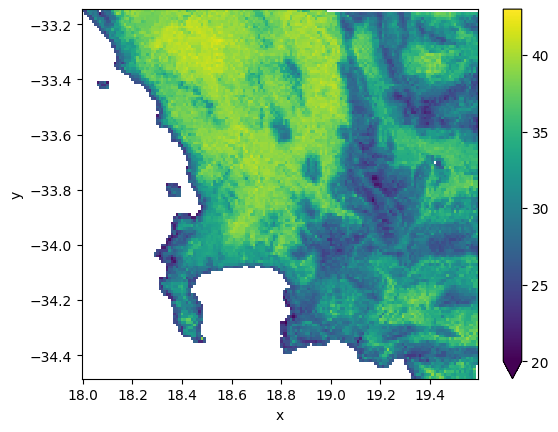

In [38]:
y_hat_t.to_xarray().T.pipe(lambda x: x-273.15).plot(vmin=20, vmax=43)

____

### Spatial Error Analysis:

In [ ]:
y_hat_test = lgb_reg.predict(X_test)

In [17]:
y_test.values

array([303.84, 303.42, 299.32, ..., 287.46, 287.84, 288.14], dtype=float32)

In [ ]:
eval = pd.DataFrame()
eval['predictions'] = y_hat_test
eval['true'] = y_test.values
eval['bias'] = eval['predictions'] - eval['true']
eval['squared_residuals'] = (eval['predictions'] - eval['true'])**2

In [ ]:
eval.set_index(y_test.index, inplace=True)

In [ ]:
eval.head()

predictions        true      bias  \
time                y      x                                          
2023-01-03 10:00:00 -33.15 18.03   309.291021  303.839996  5.451025   
                           18.04   308.161776  303.420013  4.741762   
                           18.10   303.399814  299.320007  4.079807   
                           18.11   303.399814  303.299988  0.099826   
                           18.12   310.705619  304.940002  5.765617   

                                  squared_residuals  
time                y      x                         
2023-01-03 10:00:00 -33.15 18.03          29.713674  
                           18.04          22.484309  
                           18.10          16.644824  
                           18.11           0.009965  
                           18.12          33.242337

In [ ]:
def quick_metrics(predictions, true_values):
    """
    calculation of the four main metrics
    
    Parameters:
    -----------
    predictions : array-like
        Predicted values
    true_values : array-like  
        True values
    
    Returns:
    --------
    dict : Dictionary with RMSE, MAE, Bias, R2
    """
    
    pred = np.array(predictions)
    true = np.array(true_values)
    
    # Remove NaN values
    mask = ~(np.isnan(pred) | np.isnan(true))
    pred_clean = pred[mask]
    true_clean = true[mask]
    
    rmse = np.sqrt(mean_squared_error(true_clean, pred_clean))
    mae = mean_absolute_error(true_clean, pred_clean)
    bias = np.mean(pred_clean - true_clean)
    r2 = r2_score(true_clean, pred_clean)
    
    return {
        'RMSE': rmse,
        'MAE': mae, 
        'Bias': bias,
        'R2': r2
    }

In [ ]:
quick_results = quick_metrics(eval['predictions'], eval['true'])
print(f"RMSE: {quick_results['RMSE']:.3f}°C")
print(f"MAE: {quick_results['MAE']:.3f}°C") 
print(f"Bias: {quick_results['Bias']:.3f}°C")
print(f"R²: {quick_results['R2']:.4f}")

RMSE: 4.302°C
MAE: 3.498°C
Bias: 2.488°C
R²: 0.7973


In [ ]:
ds_eval = eval.to_xarray()
ds_eval

<xarray.Dataset> Size: 37MB
Dimensions:            (time: 62, y: 134, x: 158)
Coordinates:
  * time               (time) datetime64[ns] 496B 2023-01-03T10:00:00 ... 202...
  * y                  (y) float64 1kB -34.48 -34.47 -34.46 ... -33.16 -33.15
  * x                  (x) float64 1kB 18.02 18.03 18.04 ... 19.57 19.58 19.59
Data variables:
    predictions        (time, y, x) float64 11MB nan nan nan ... 307.2 306.0
    true               (time, y, x) float32 5MB nan nan nan ... 309.8 309.6
    bias               (time, y, x) float64 11MB nan nan nan ... -2.556 -3.625
    squared_residuals  (time, y, x) float64 11MB nan nan nan ... 6.533 13.14

In [ ]:
clim = ds_eval.squared_residuals.groupby("time.month").mean()
clim

<xarray.DataArray 'squared_residuals' (month: 11, y: 134, x: 158)> Size: 2MB
array([[[         nan,          nan,          nan, ...,  41.86469562,
          98.74060862,  29.13592481],
        [         nan,          nan,          nan, ...,  31.43265643,
          29.3942293 ,  18.50864593],
        [         nan,          nan,          nan, ...,  37.73884379,
          62.50190853,  20.29548875],
        ...,
        [         nan,          nan,  36.03150041, ...,  29.3925677 ,
          41.94892066,  37.9190884 ],
        [         nan,  23.21062518,  50.51001983, ...,  35.25924685,
          34.66533881,  22.74537354],
        [ 26.07392595,  50.64974818,  50.08643465, ...,  11.40379923,
          10.3487819 ,  13.22507351]],

       [[         nan,          nan,          nan, ...,  15.08067369,
          69.85470528,  16.31720029],
        [         nan,          nan,          nan, ...,  14.47405077,
          17.09294907,  13.21861303],
        [         nan,          nan,          nan, ...,  27.20852964,
          36.89658353,  11.8276799 ],
...
        [         nan,          nan,  45.27915724, ...,  31.82130514,
          43.43117132,  39.6060257 ],
        [         nan,  23.37473701,  50.11532394, ...,  38.6342874 ,
          35.24868989,  23.12393315],
        [ 19.16207472,  41.83533498,  43.20529151, ...,  13.5725447 ,
          11.42215183,  20.64680119]],

       [[         nan,          nan,          nan, ...,  54.60086309,
         146.79903878,  42.54716241],
        [         nan,          nan,          nan, ...,  38.25622818,
          59.68928065,  24.44276162],
        [         nan,          nan,          nan, ...,  41.97602768,
          71.38236104,  42.96255414],
        ...,
        [         nan,          nan,  58.40945589, ...,  16.40809776,
          24.8838244 ,  21.99202606],
        [         nan,  55.76640778,  99.4954279 , ...,  21.62252051,
          22.4322049 ,   8.34115188],
        [ 55.43285522,  89.85877241,  73.35753271, ...,   1.32950684,
           1.64692753,   5.54972836]]])
Coordinates:
  * y        (y) float64 1kB -34.48 -34.47 -34.46 ... -33.17 -33.16 -33.15
  * x        (x) float64 1kB 18.02 18.03 18.04 18.05 ... 19.56 19.57 19.58 19.59
  * month    (month) int64 88B 1 2 3 4 5 7 8 9 10 11 12

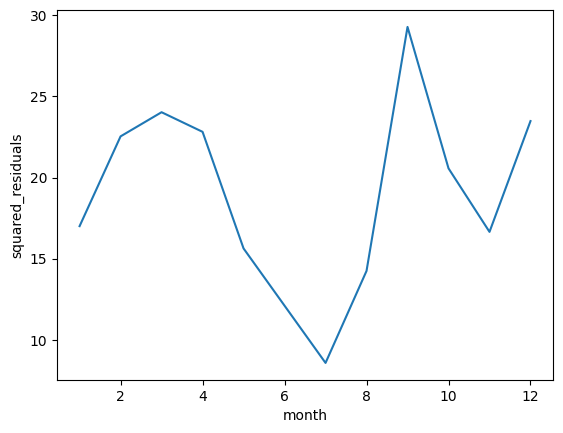

In [ ]:
clim.mean(['x','y']).plot()

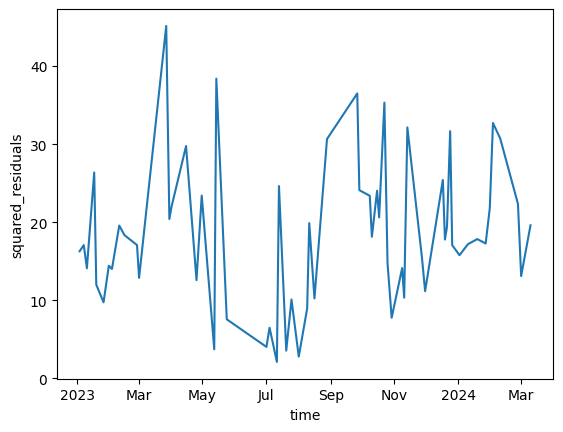

In [ ]:
ds_eval.squared_residuals.mean(['x','y']).plot()

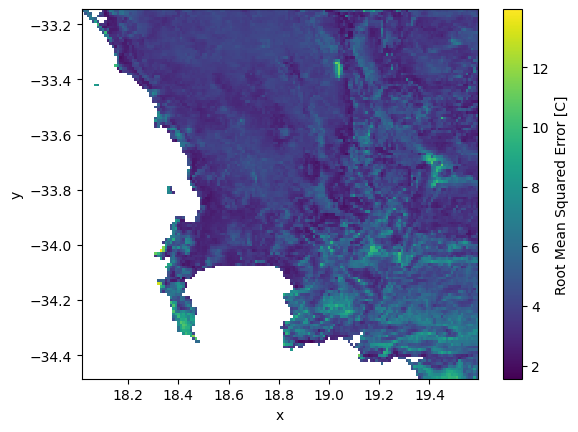

In [ ]:
rmse_ds = np.sqrt(ds_eval.squared_residuals.mean('time'))
rmse_ds.name = "RMSE"
rmse_ds.attrs['standard_name'] = "Root Mean Squared Error"
rmse_ds.attrs['units'] = "C"
rmse_ds.plot()

In [38]:
rmse_ds

<xarray.DataArray 'RMSE' (y: 134, x: 158)> Size: 169kB
array([[       nan,        nan,        nan, ..., 3.81707542, 7.40757028,
               nan],
       [       nan,        nan,        nan, ..., 4.25314906, 5.24475491,
               nan],
       [       nan,        nan,        nan, ..., 5.10196497, 5.87084364,
               nan],
       ...,
       [       nan,        nan, 6.00593869, ..., 5.33459959, 5.77612218,
        5.28034341],
       [       nan, 5.57950486, 7.93100568, ..., 5.68291951, 5.75214894,
        4.96134841],
       [6.18503499, 7.39118467, 6.68871074, ...,        nan,        nan,
               nan]], shape=(134, 158))
Coordinates:
  * y        (y) float64 1kB -34.48 -34.47 -34.46 ... -33.17 -33.16 -33.15
  * x        (x) float64 1kB 18.02 18.03 18.04 18.05 ... 19.56 19.57 19.58 19.59
Attributes:
    standard_name:  Root Mean Squared Error
    units:          C

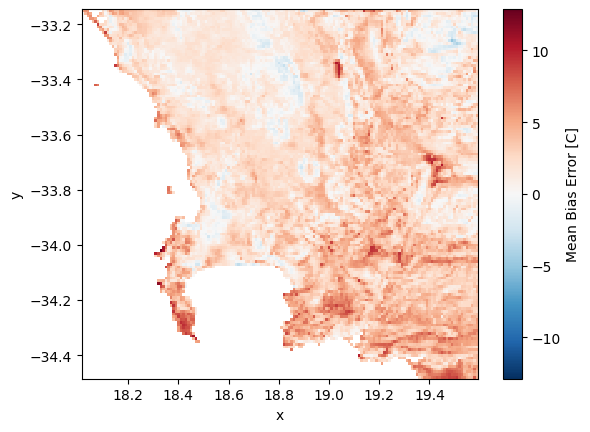

In [ ]:
bias_ds = ds_eval.bias.mean('time')
bias_ds.attrs['standard_name'] = "Mean Bias Error"
bias_ds.attrs['units'] = "C"
bias_ds.plot()

### Evalaution across Sets

In [ ]:
def evaluate_regression_model(model, X, y, dataset_name=""):
    # make y a series with time, x, y as index
    """Calculate and print regression metrics for model evaluation"""
    y_pred = model.predict(X)
    
    # metrics
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    evs = explained_variance_score(y, y_pred)
    
    print(f"\n===== {dataset_name} Performance Metrics =====")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Explained Variance: {evs:.4f}")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'evs': evs,
        'y_true': y,
        'y_pred': y_pred
    }

In [ ]:
# Evaluate on different datasets
train_metrics = evaluate_regression_model(lgbm, X_train, y_train, "Training")
val_metrics = evaluate_regression_model(lgbm, X_val, y_val, "Validation")
test_metrics = evaluate_regression_model(lgbm, X_test, y_test, "Test")

In [20]:
def plot_prediction_scatter(y_true, y_pred, ax, title="Predicted vs Actual Values"):
    # Plot the scatter points
    ax.scatter(y_true, y_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    # Add labels and title
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(title)
    
    # Add R² annotation
    r2 = r2_score(y_true, y_pred)
    ax.annotate(f"R² = {r2:.4f}", xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    ax.grid(True, alpha=0.3)


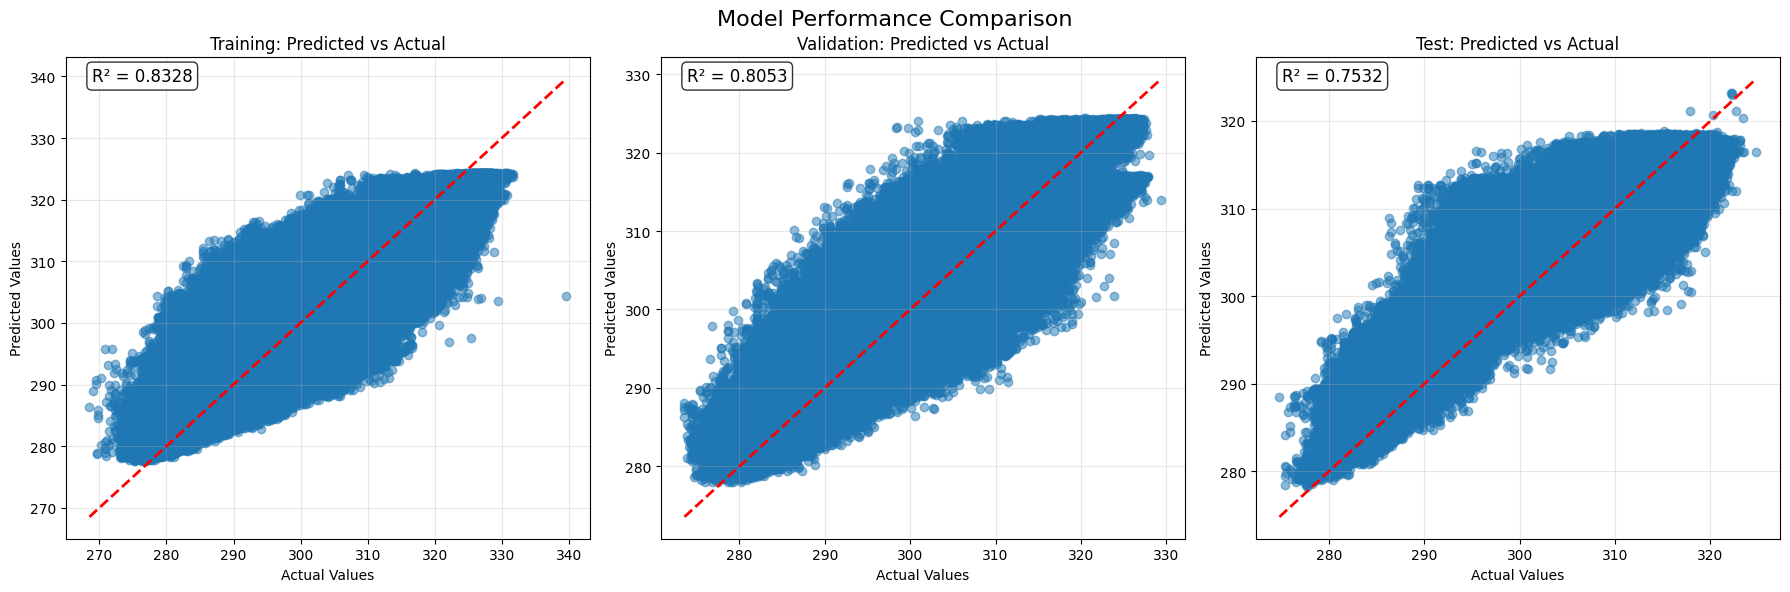

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot each dataset in its own subplot
plot_prediction_scatter(train_metrics['y_true'], train_metrics['y_pred'], axes[0], "Training: Predicted vs Actual")
plot_prediction_scatter(val_metrics['y_true'], val_metrics['y_pred'], axes[1], "Validation: Predicted vs Actual")
plot_prediction_scatter(test_metrics['y_true'], test_metrics['y_pred'], axes[2], "Test: Predicted vs Actual")

fig.suptitle("Model Performance Comparison", fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

In [ ]:
# saving model:
dump(lgb_reg, './models/lgbm_model.joblib')

# #load model:
# lgbm = load('./models/lgbm_model.joblib')

['./models/lgbm_model.joblib']

### Experimenting with XGBoost default hyperparamters:

In [9]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [10]:
evallist = [(dtrain, 'train'), (dval, 'validation')]

In [13]:
params = {
    'objective': 'reg:squarederror',  # For regression
    'booster': 'gbtree',
    'nthread': -1
}

In [16]:
model = xgb.train(
    params,
    dtrain,
    evals=evallist,
    early_stopping_rounds=50,         # Stop if no improvement for 50 rounds
    verbose_eval=10                   # Print progress every 10 iterations
)

[0]	train-rmse:7.63678	validation-rmse:7.24097
[9]	train-rmse:4.25080	validation-rmse:4.15368


In [ ]:
def evaluate_regression_model(model, X, y, dataset_name=""):
    # make y a series with time, x, y as index
    """Calculate and print regression metrics for model evaluation"""
    y_pred = model.predict(X)
    
    # metrics
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    evs = explained_variance_score(y, y_pred)
    
    print(f"\n===== {dataset_name} Performance Metrics =====")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Explained Variance: {evs:.4f}")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'evs': evs,
        'y_true': y,
        'y_pred': y_pred
    }

In [24]:
# Evaluate on different datasets
train_metrics_xgb = evaluate_regression_model(model, dtrain, y_train, "Training")
val_metrics_xgb = evaluate_regression_model(model, dval, y_val, "Validation")
test_metrics_xgb = evaluate_regression_model(model, dtest, y_test, "Test")


===== Training Performance Metrics =====
RMSE: 4.2508
MAE: 3.2506
R²: 0.8146
Explained Variance: 0.8146

===== Validation Performance Metrics =====
RMSE: 4.1537
MAE: 3.2441
R²: 0.8072
Explained Variance: 0.8167

===== Test Performance Metrics =====
RMSE: 4.2665
MAE: 3.3699
R²: 0.7549
Explained Variance: 0.7985
